# Notes
* Something is amiss with the LASSO regression, which could mean the processing is messed up as well. 

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
from keras import models, layers
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Lasso
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, median_absolute_error
from scipy.stats import linregress
from google.colab import files
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

np.set_printoptions(suppress=True)
plt.rcParams['font.family']='serif'

In [126]:
combined_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/fixed_merged.csv')

combined_df = combined_df.sample(frac=1) # shuffle the dataframe

freqs_1, freqs_2, freqs_3 = (np.array(combined_df[arr_name]) for arr_name in ['first_par1s', 'second_par1s', 'third_par1s'])

def normalize(x):
    x = (x-min(x))/(max(x)-min(x))
    return x

shared_columns = ['hardness', 'num_qpos', 'tins', 'disk_norm',
                  'gammas', 'nthcomp_norms', 'red_fit_stats', 'count_rates', 
                  'bg_ratio','intensities'] # add num qpos later 

df_1 = combined_df[['first_par1s', 'first_par2s']+shared_columns]

df_2 = combined_df[['second_par1s', 'second_par2s']+shared_columns]

df_3 = combined_df[['third_par1s', 'third_par2s']+shared_columns]

dfs = [df_1, df_2, df_3]

good_indices = np.array([np.where(arr!=0)[0] for arr in [freqs_1, freqs_2, freqs_3]])

df_1, df_2, df_3 = (dfs[i].iloc[good_indices[i]] for i in range(3))

for df in [df_1, df_2, df_3]:
    df.keys().values[[0, 1]] = ['freq', 'fwhm']

combined_df = pd.concat([df_1, df_2, df_3]) 

arr_names =  ['freq', 'fwhm', 'hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
(freqs, fwhms, hardness, tins, disk_norms, gammas, nthcomp_norms, intensities) = (normalize(np.array(combined_df[arr_name])) for arr_name in arr_names)
num_qpos = np.array(combined_df['num_qpos']).astype(int)

X = np.array([]).reshape(0,8)

for a, b, c, d, e, f, g, h in zip(freqs, hardness, tins, disk_norms, gammas, nthcomp_norms, intensities, num_qpos): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e), 
                        float(f), float(g), float(h)])
    X = np.vstack([X, new_arr])

x_arr_names = ['freq', 'hardness', 'tins', 'disk_norm', 'gammas', 
               'nthcomp_norms', 'intensities', 'num_qpos']
x_df = pd.DataFrame(X, columns=x_arr_names)


X_train, X_test, y_train, y_test = train_test_split(x_df,fwhms, test_size=0.15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


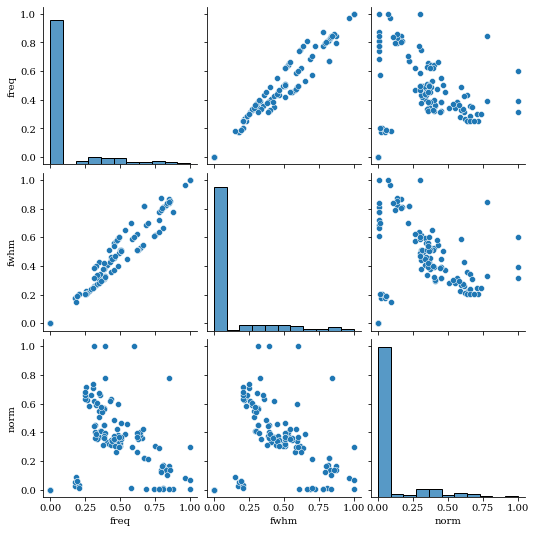

In [139]:
# Pairplot

merged_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/fixed_merged.csv')

freqs = np.concatenate((merged_df['first_par1s'], merged_df['second_par1s'], merged_df['third_par1s']))
widths = np.concatenate((merged_df['first_par2s'], merged_df['second_par2s'], merged_df['third_par2s']))
norms = np.concatenate((merged_df['first_norms'], merged_df['second_norms'], merged_df['third_norms']))

df = pd.DataFrame(list(zip(freqs, widths, norms)), columns=['freq', 'width', 'norm'])

df = df.loc[(df!=0).any(axis=1)]

qpo_df = pd.DataFrame(np.transpose([all_freqs, all_fwhms, all_norms]), columns=['freq', 'fwhm', 'norm'])

sns.pairplot(qpo_df)
plt.show()

## LASSO

In [135]:
def lasso(X_train, y_train, X_test): 
    regressor = Lasso(alpha=0.25, fit_intercept=True, max_iter=5000)
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    return predictions

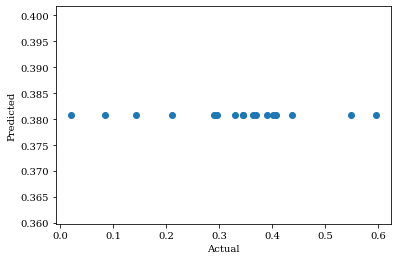

In [136]:
predictions = lasso(X_train, y_train, X_test)

plt.scatter(y_test, predictions)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

## KNN

In [137]:
knn = KNeighborsRegressor(2)#, weights='distance')
knn = knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

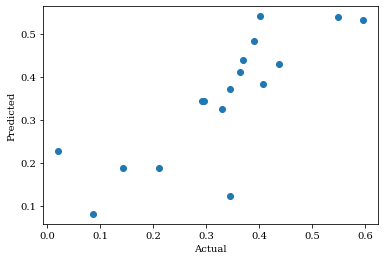

In [138]:
plt.scatter(y_test, predictions)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()